In [3]:
import pandas as pd
from geographiclib.geodesic import Geodesic
import math
import folium
geod = Geodesic.WGS84 
import datetime

In [4]:
data = 'obc_tanker_cargo.csv'
df = pd.read_csv(data)

In [56]:
df.head()

,MSG_TYPE,MMSI,NAME,IMO_NUMBER,CALL_SIGN,LAT_AVG,LON_AVG,PERIOD,SPEED_KNOTS,COG_DEG,...,SHIP_AND_CARGO_TYPE,DRAUGHT,DRAUGHT.1,DIM_BOW,DIM_STERN,DIM_PORT,DIM_STARBOARD,DESTINATION,MMSI_COUNTRY_CD,RECEIVER
0,1,323150000,LPG EMILIA,9242209.0,CLBS,22.779250,-78.741867,2023-04-01 00:00:00.000,14.7,110.0,...,80,8.4,8.4,143,35,14,14,FOR ORDERS,CU,NaN
1,1,334976000,BELEN,9196230.0,HQZX5,23.218183,-78.842584,2023-04-01 00:00:00.000,10.2,323.4,...,70,3.6,3.6,80,10,5,9,USMIA,HN,NaN
2,1,319103800,STOLT SINCERITY,9680085.0,ZGEY,22.423079,-77.790762,2023-04-01 00:00:00.000,13.7,302.6,...,80,10.5,10.5,155,30,18,14,INKAK,KY,rORBCOMM000
3,1,323150000,LPG EMILIA,9242209.0,CLBS,22.701027,-78.515972,2023-04-01 00:55:00.000,14.8,109.0,...,80,8.4,8.4,143,35,14,14,FOR ORDERS,CU,NaN
4,1,334979000,SARA REGINA,9142655.0,HQZX8,21.862225,-76.873167,2023-04-01 00:55:00.000,10.9,294.0,...,70,3.8,3.8,79,12,7,7,USMIA,HN,NaN


In [4]:
df['LENGTH'] = df['DIM_STERN'] + df['DIM_BOW']
df['BEAM'] = df['DIM_PORT'] + df['DIM_STARBOARD']
df.shape

(131308, 25)

In [5]:
df.columns

Index(['MSG_TYPE', 'MMSI', 'NAME', 'IMO_NUMBER', 'CALL_SIGN', 'LAT_AVG',
       'LON_AVG', 'PERIOD', 'SPEED_KNOTS', 'COG_DEG', 'HEADING_DEG',
       'NAV_STATUS', 'NAV_SENSOR', 'SHIP_AND_CARGO_TYPE', 'DRAUGHT',
       'DRAUGHT.1', 'DIM_BOW', 'DIM_STERN', 'DIM_PORT', 'DIM_STARBOARD',
       'DESTINATION', 'MMSI_COUNTRY_CD', 'RECEIVER', 'LENGTH', 'BEAM'],
      dtype='object')

In [6]:
df['PERIOD'] = pd.to_datetime(df['PERIOD'])
df['DATE'] = df['PERIOD'].dt.date
df['TIME'] = df['PERIOD'].dt.time

In [60]:
df['MMSI'].nunique()

3633

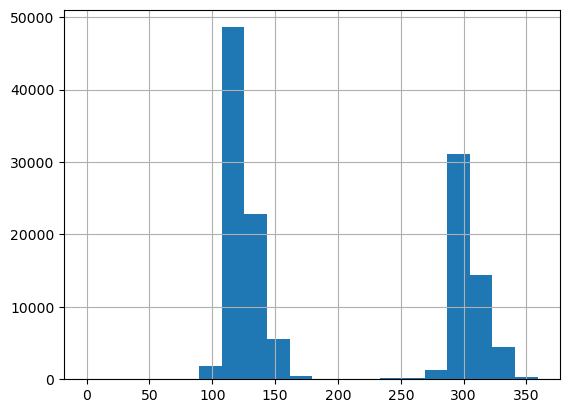

In [61]:
cog_hist = df['COG_DEG'].hist(bins=20)

In [62]:
df['CHANNEL_SIDE'] = ['Northwestbound' if x > 200 else 'Southeastbound' for x in df['COG_DEG']]

In [73]:
voyage_stats = df[['MMSI', 'PERIOD', 'CHANNEL_SIDE', 'LAT_AVG', 'LON_AVG', 'DATE']].sort_values(['MMSI', 'PERIOD'])
voyage_stats['time_diff'] = (voyage_stats.groupby('MMSI')['PERIOD'].diff().dt.total_seconds())

threshold = 3 * 3600
voyage_stats['new_voyage'] = (voyage_stats['time_diff'] > threshold)
voyage_stats['voyage_id'] = (voyage_stats.groupby('MMSI')['new_voyage'].cumsum()+1)

In [70]:
voyage_stats['time_diff_min'] = voyage_stats['time_diff'] / 60
voyage_stats['time_diff_min'].describe()

count    1.276750e+05
mean     4.850729e+03
std      4.350510e+04
min      5.000000e+00
25%      5.000000e+00
50%      1.000000e+01
75%      5.000000e+01
max      1.344525e+06
Name: time_diff_min, dtype: float64

In [78]:
voyage_stats['voyage_id'].describe()

count    131308.000000
mean         19.722309
std          35.541316
min           1.000000
25%           1.000000
50%           4.000000
75%          19.000000
max         254.000000
Name: voyage_id, dtype: float64

In [84]:
ping_counts = (voyage_stats.groupby(['MMSI', 'voyage_id']).size().reset_index(name='num_pings'))
ping_counts['num_pings'].describe()

count    17042.000000
mean         7.704964
std         11.652718
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max        167.000000
Name: num_pings, dtype: float64

<Axes: >

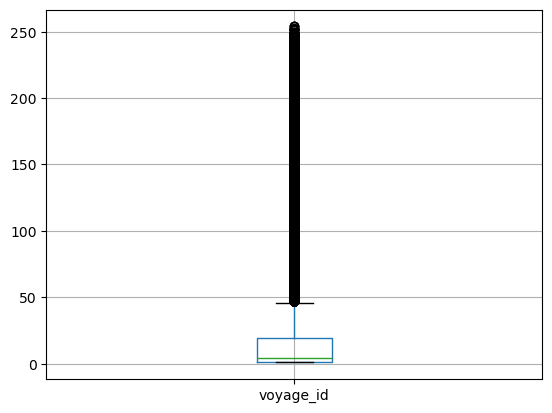

In [77]:
voyage_stats.boxplot(column='voyage_id')

<Axes: >

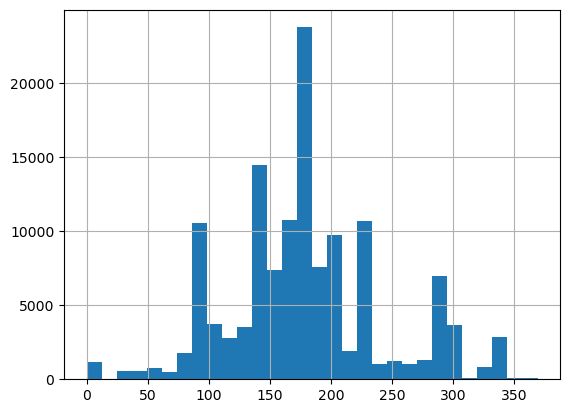

In [88]:
df['LENGTH'].hist(bins=30)

<Axes: >

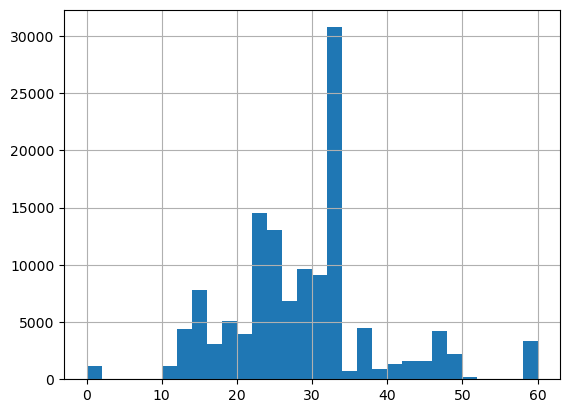

In [89]:
df['BEAM'].hist(bins=30)

<Axes: >

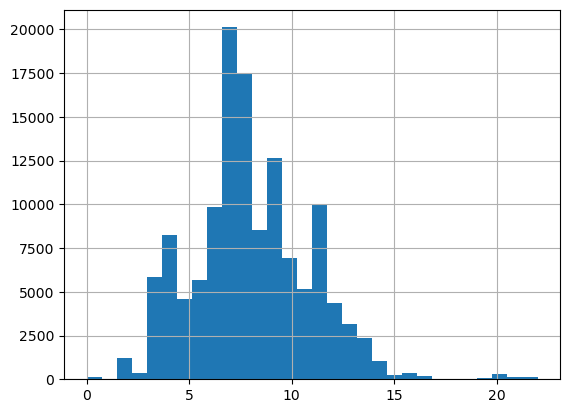

In [91]:
df['DRAUGHT'].hist(bins=30)

In [67]:
x=df.groupby('MMSI')['voyage_id']
x

In [60]:
pings_per_voyage = df.groupby('MMSI')['voyage_id'].value_counts()
pings_per_voyage

MMSI       voyage_id
205042000  0            16
205082000  1            12
           0             4
205086000  1             7
           0             6
                        ..
720202000  43            1
           49            1
           52            1
           55            1
           57            1
Name: count, Length: 17042, dtype: int64

<Axes: >

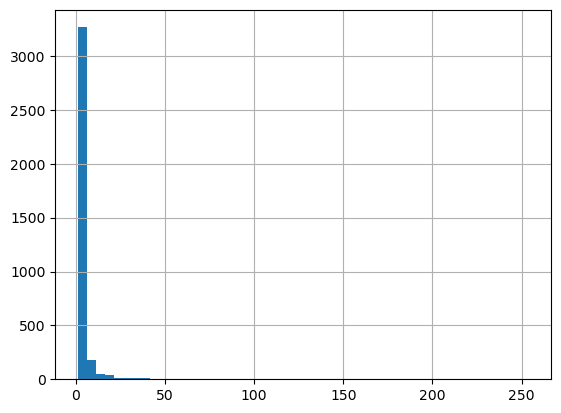

In [52]:
voyage_counts.hist(bins=50)

In [34]:
df['CHANNEL_SIDE'].value_counts()

CHANNEL_SIDE
Southeastbound    79496
Northwestbound    51812
Name: count, dtype: int64

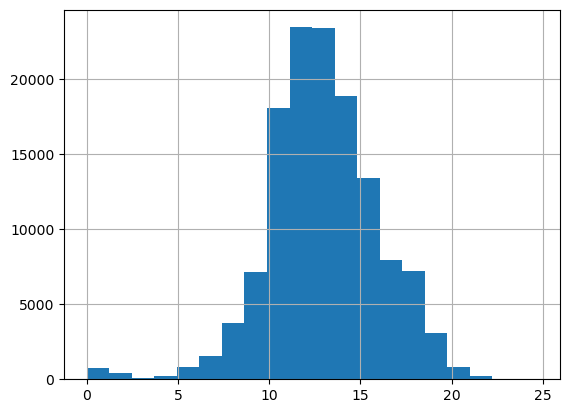

In [23]:
sog_hist = df['SPEED_KNOTS'].hist(bins=20)

In [ ]:
sog_hist = df['SPEED_KNOTS'].hist(bins=20)

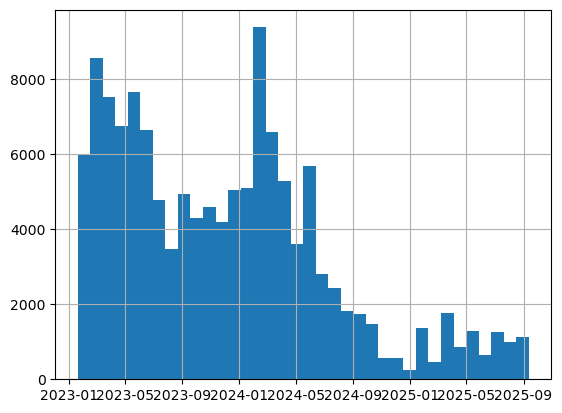

In [29]:
date_hist = df['DATE'].hist(bins=36)

In [32]:
df['NAV_STATUS'].value_counts()

NAV_STATUS
0.0     128769
8.0       1313
2.0        551
5.0        373
3.0        115
1.0         55
9.0         29
15.0        16
4.0         16
11.0        13
Name: count, dtype: int64

In [5]:
df['SHIP_AND_CARGO_TYPE'].value_counts()

SHIP_AND_CARGO_TYPE
70    63595
80    27607
79    17685
71     6084
89     4510
74     3251
84     2152
81     1958
82     1469
72      636
83      523
77      494
75      424
85      398
73      172
78      170
76      113
88       66
87        1
Name: count, dtype: int64

In [7]:
df_sailing = df[df['NAV_STATUS']==8]

In [8]:
df_sailing['MMSI'].nunique()

45

In [40]:
m = folium.Map(location=[22.5, -77.8], zoom_start=11)

In [11]:
for i in range(len(df)):
    folium.Marker(
        location=[df.iloc[i]['LAT_AVG'], df.iloc[i]['LON_AVG']],
        popup=df.iloc[i]['MMSI']
    ).add_to(m)

Add channel boundaries to map

In [41]:
data = pd.read_csv('obc_boundaries.csv')
lats = list(data['Lat'])
longs = list(data['Long'])

all_coords = []
counter = 0
for i in range(3):
    coords = []
    for j in range(4):
        coords.append([lats[counter], longs[counter]])
        counter += 1
    all_coords.append(coords)

for i in range(3):
    trail_coordinates = all_coords[i]
    folium.PolyLine(locations = trail_coordinates, color="#FF0000", weight=2).add_to(m)

In [42]:
m

In [130]:
box1 = [[22.84101667, -78.72296667],[22.55308333, -78.13211667]]
box2 = [[22.62481667, -78.0874], [22.2885, -77.68085]]
box3 = [[22.3528, -77.63613333], [22.12445, -77.49385]]
boxes = [box1, box2, box3]
for box in boxes:
    for i in range(2):
        folium.Marker(location=box[i]).add_to(m)

In [131]:
m

In [21]:
data.head(8)

,Index,Lat,Long,Line,geometry
0,1,22.841017,-78.722967,North,"(-78.72296667, 22.84101667)"
1,2,22.624817,-78.087400,North,"(-78.0874, 22.62481667)"
2,3,22.352800,-77.636133,North,"(-77.63613333, 22.3528)"
3,4,22.183783,-77.442350,North,"(-77.44235, 22.18378333)"
4,1,22.776950,-78.783950,South,"(-78.78395, 22.77695)"
5,2,22.553083,-78.132117,South,"(-78.13211667, 22.55308333)"
6,3,22.288500,-77.680850,South,"(-77.68085, 22.2885)"
7,4,22.124450,-77.493850,South,"(-77.49385, 22.12445)"


In [43]:
from shapely.geometry import Point
from shapely.geometry import Polygon
data = data[data['Line']!='Middle']
data['geometry'] = data.apply(lambda x: (float(x.Long), float(x.Lat)), axis=1)

In [44]:
channel_coords = list(data['geometry'])
channel_coords_reorder = [channel_coords[0], channel_coords[1], channel_coords[2], channel_coords[3], channel_coords[-1], channel_coords[-2], channel_coords[-3], channel_coords[-4]]
channel_polygon = Polygon(channel_coords_reorder)
geo_df_channel = geopandas.GeoDataFrame(geometry=[channel_polygon], crs='EPSG:4326')

In [45]:
geo_df_vessels = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['LON_AVG'], df['LAT_AVG']), crs='EPSG:4326')

In [1]:
def where_is_vessel(LAT_AVG, LON_AVG, BOOL):
    if BOOL == True:
        answer = 'in channel'
    elif LON_AVG < -78.72296667:
        answer = 'west'
    elif LON_AVG > -77.49385:
        answer = 'east'
    elif LAT_AVG > 22.84101667:
        answer = 'north'
    elif LAT_AVG < 22.12445:
        answer = 'south'
    return answer
    

In [54]:
geo_df_vessels['in_channel'] = geo_df_vessels.within(channel_polygon)
geo_df_vessels['location'] = geo_df_vessels.apply(lambda x: where_is_vessel(x.LAT_AVG, x.LON_AVG, x.in_channel), axis=1)
geo_df_vessels.head()

In [90]:
geo_df_vessels['in_channel'].value_counts()

in_channel
False    71140
True     60168
Name: count, dtype: int64

In [153]:
df['box1'] = (df["LAT_AVG"] <= box1[0][0]) & (df["LAT_AVG"] >= box1[1][0]) & (df["LON_AVG"] >= box1[0][1]) & (df["LON_AVG"] <= box1[1][1])
df['box2'] = (df["LAT_AVG"] <= box2[0][0]) & (df["LAT_AVG"] >= box2[1][0]) & (df["LON_AVG"] >= box2[0][1]) & (df["LON_AVG"] <= box2[1][1])
df['box3'] = (df["LAT_AVG"] <= box3[0][0]) & (df["LAT_AVG"] >= box3[1][0]) & (df["LON_AVG"] >= box3[0][1]) & (df["LON_AVG"] <= box3[1][1])
df['out_of_channel'] = (df['box1'] == False) & (df['box2'] == False) & (df['box3']==False)
df['out_of_channel'].value_counts()

out_of_channel
True     75315
False    55993
Name: count, dtype: int64